<a href="https://colab.research.google.com/github/zhiyingproject/tongueDiagnosis/blob/main/imgSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This notebook is to train a model for locating tongues from people's faces. It is for tongue diagnosis using traditional Chinese Medical Theory (TCM)
!pip uninstall keras-nightly
!pip install h5py==2.10.0
!pip install --upgrade tensorflow==1.15.0
!pip install --upgrade tensorflow-gpu==1.15
# !pip install --upgrade keras==2.2.4
!python -m pip install -U scikit-image==0.16.2
# !pip uninstall keras 
!pip install keras==2.2.4
!pip install wcmatch
# %tensorflow_version 1.x

     |████████████████████████████████| 2.9 MB 8.1 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires h5py~=3.1.0, but you have h5py 2.10.0 which is incompatible.
     |████████████████████████████████| 412.3 MB 24 kB/s 
     |████████████████████████████████| 3.8 MB 57.9 MB/s 
     |████████████████████████████████| 50 kB 9.0 MB/s 
     |████████████████████████████████| 503 kB 74.0 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=bd1479ddefdaa3718eb1afe3b51e5c54d51e70138f100ef585c558e14f2de802
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorf

In [2]:
# Restarting the kernel to enable tensorflow v1.14
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [3]:
# Install Mask RCNN
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 33.11 MiB/s, done.
Resolving deltas: 100% (562/562), done.


In [4]:
cd Mask_RCNN/

/content/Mask_RCNN


In [5]:
# Setup libraries for Mas RCNN
!python setup.py install
!pip show mask-rcnn

/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'ma

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:

import pathlib
import shutil
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import sys
from mrcnn.utils import Dataset, extract_bboxes, compute_ap
from mrcnn.config import Config
from mrcnn.visualize import display_instances
from numpy import zeros, asarray
from tensorflow.keras.utils import plot_model
from mrcnn.model import MaskRCNN, load_image_gt, mold_image
from numpy import zeros, asarray, expand_dims, mean
import math

Using TensorFlow backend.


In [8]:

from wcmatch.pathlib import Path
ds_path = '/content/drive/MyDrive/backup/tongueDiagnosis/segTraining'
num_files = len(list(Path(ds_path).rglob(['*.jpg', '*.JPG', '*.jpeg'])))
training_threshold = int(num_files * 0.9)
print(training_threshold, num_files - training_threshold)
model_path = '/content/drive/MyDrive/backup/tongueDiagnosis/models'

485 54


In [9]:
class tongueDataset(Dataset):
    def load_dataset(self, dataset_dir, is_train=True):
        self.add_class("dataset", 1, "tongue")

        images_dir = dataset_dir
        annotations_dir = f'{dataset_dir}/annots'
        image_files = Path(dataset_dir).rglob(['*.jpg','*.JPG','*.jpeg'])
        for ifile, filename in enumerate(list(image_files)):
            image_id = filename.stem
            if is_train and ifile >= training_threshold:
                continue
            if not is_train and ifile < training_threshold:
                continue
            img_path = filename
            ann_path = f'{annotations_dir}/{filename.stem}.xml'
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    def extract_boxes(self, filename):
        tree = ET.parse(filename)
        root = tree.getroot()
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['annotation']
        boxes, w, h = self.extract_boxes(path)
        masks = zeros([h, w, len(boxes)], dtype='uint8')

        class_ids = []
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('tongue'))
        return masks, asarray(class_ids, dtype='int32')

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [10]:
class tongueConfig(Config):
    NAME = 'tongue_cfg'
    NUM_CLASSES = 1 + 1
    STEPS_PER_EPOCH = training_threshold
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

In [11]:
training_ds = tongueDataset()
training_ds.load_dataset(ds_path, is_train=True)
training_ds.prepare()
print('Train: %d' % len(training_ds.image_ids))

test_ds = tongueDataset()
test_ds.load_dataset(ds_path, is_train=False)
test_ds.prepare()
print('Test: %d' % len(test_ds.image_ids))

Train: 485
Test: 54


In [12]:
config = tongueConfig()
config.display()

model = MaskRCNN(mode='training', model_dir=model_path, config=config)
model.load_weights('/content/drive/MyDrive/backup/tongueDiagnosis/models/mask_rcnn_coco.h5', 
                   by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
model.train(training_ds, test_ds, learning_rate=config.LEARNING_RATE, epochs=16, layers='heads')



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.7/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/16
485/485 [==============================] - 261s 538ms/step - loss: 0.8097 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.2151 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.2939 - mrcnn_mask_loss: 0.2755 - val_loss: 0.8909 - val_rpn_class_loss: 0.0038 - val_rpn_bbox_loss: 0.4195 - val_mrcnn_class_loss: 0.0092 - val_mrcnn_bbox_loss: 0.2120 - val_mrcnn_mask_loss: 0.2465

Epoch 2/16
485/485 [==============================] - 238s 491ms/step - loss: 0.4895 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1812 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.1260 - mrcnn_mask_loss: 0.1656 - val_loss: 1.0135 - val_rpn_class_loss: 0.0124 - val_rpn_bbox_loss: 0.5111 - val_mrcnn_class_loss: 0.0079 - val_mrcnn_bbox_loss: 0.2403 - val_mrcnn_mask_loss: 0.2418
Epoch 3/16
485/485 [==============================] - 241s 497ms/step - loss: 0.4342 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.1735 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.0946 - mrcnn_mask_loss: 0.1534 - val_loss: 0.6618 - val

In [12]:
class predictionConfig(Config):
    NAME = 'tongue_cfg'
    NUM_CLASSES = 1 + 1
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

In [36]:
def evaluate_model(ds, model, cfg):
    APs = list()
    for i, img_id in enumerate(ds.image_ids):
        print(ds.image_info[i])
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(ds, cfg, img_id, use_mini_mask=False)
        scaled_image = mold_image(image, cfg)
        sample = expand_dims(scaled_image, 0)
        yhat = model.detect(sample, verbose=0)
        r = yhat[0]
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'],0.65)
        print(AP)
        if math.isnan(AP):
            continue
        APs.append(AP)
    mAP = mean(APs)
    return mAP

In [14]:

training_ds = tongueDataset()
training_ds.load_dataset(ds_path, is_train=True)
training_ds.prepare()
print('Train: %d' % len(training_ds.image_ids))

test_ds = tongueDataset()
test_ds.load_dataset(ds_path, is_train=False)
test_ds.prepare()
print('Test: %d' % len(test_ds.image_ids))


weights_file = '/content/drive/MyDrive/backup/tongueDiagnosis/models/mask_rcnn_tongue_cfg_0016.h5'  # !!!!!need to identify
print(model_path)
cfg_pred = predictionConfig()
model = MaskRCNN(mode='inference', model_dir=model_path, config=cfg_pred)
model.load_weights(weights_file, by_name=True)

Train: 485
Test: 54
/content/drive/MyDrive/backup/tongueDiagnosis/models







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.








In [37]:
train_mAP = evaluate_model(test_ds, model, cfg_pred)
print("Test mAP: %.3f" % train_mAP)

{'id': 'IMG_5816', 'source': 'dataset', 'path': PosixPath('/content/drive/MyDrive/backup/tongueDiagnosis/segTraining/IMG_5816.JPG'), 'annotation': '/content/drive/MyDrive/backup/tongueDiagnosis/segTraining/annots/IMG_5816.xml'}
1.0
{'id': 'IMG_5792', 'source': 'dataset', 'path': PosixPath('/content/drive/MyDrive/backup/tongueDiagnosis/segTraining/IMG_5792.JPG'), 'annotation': '/content/drive/MyDrive/backup/tongueDiagnosis/segTraining/annots/IMG_5792.xml'}
1.0
{'id': 'IMG_5813', 'source': 'dataset', 'path': PosixPath('/content/drive/MyDrive/backup/tongueDiagnosis/segTraining/IMG_5813.JPG'), 'annotation': '/content/drive/MyDrive/backup/tongueDiagnosis/segTraining/annots/IMG_5813.xml'}
1.0
{'id': 'IMG_5786', 'source': 'dataset', 'path': PosixPath('/content/drive/MyDrive/backup/tongueDiagnosis/segTraining/IMG_5786.JPG'), 'annotation': '/content/drive/MyDrive/backup/tongueDiagnosis/segTraining/annots/IMG_5786.xml'}
1.0
{'id': 'IMG_5750', 'source': 'dataset', 'path': PosixPath('/content/driv

In [49]:
def plot_actual_vs_predicted(ds, model, cfg, start, end):
    i = 0
    for i_img in range(start, end):
        image = ds.load_image(i_img)
        n_image = end - start + 1
        print(ds.image_info[i_img]['id'])
        mask, _ = ds.load_mask(i_img)
        scaled_image = mold_image(image, cfg)
        sample = expand_dims(scaled_image, 0)
        yhat = model.detect(sample, verbose=0)[0]
        plt.subplot(n_image, 2, i*2+1)
        plt.imshow(image)
        # plt.title('Actual')
        for j in range(mask.shape[2]):
            plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
        plt.subplot(n_image, 2, i*2+2)
        plt.imshow(image)
        # plt.title('Predict')
        ax = plt.gca()
        for box in yhat['rois']:
            y1, x1, y2, x2 = box
            width, height = x2 - x1, y2 - y1
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            ax.add_patch(rect)
        i += 1
    plt.show()

IMG_5778
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
IMG_5744
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
IMG_5752
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
IMG_5734
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
IMG_5735
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


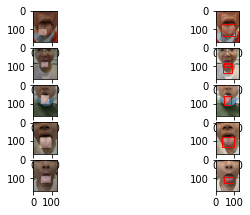

In [50]:
from matplotlib.patches import Rectangle
plot_actual_vs_predicted(test_ds, model, cfg_pred, 5,10)